In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/simulate-n-brackets/__results__.html
/kaggle/input/simulate-n-brackets/submission.csv
/kaggle/input/simulate-n-brackets/__resultx__.html
/kaggle/input/simulate-n-brackets/__notebook__.ipynb
/kaggle/input/simulate-n-brackets/__output__.json
/kaggle/input/simulate-n-brackets/custom.css
/kaggle/input/march-machine-learning-mania-2024/Conferences.csv
/kaggle/input/march-machine-learning-mania-2024/sample_submission.csv
/kaggle/input/march-machine-learning-mania-2024/WNCAATourneyDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2024/WRegularSeasonCompactResults.csv
/kaggle/input/march-machine-learning-mania-2024/MNCAATourneySeedRoundSlots.csv
/kaggle/input/march-machine-learning-mania-2024/MRegularSeasonDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2024/MNCAATourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2024/MGameCities.csv
/kaggle/input/march-machine-learning-mania-2024/WGameCities.csv
/kaggle/input/march-machine-learning-m

**Introduction:**

The analysis of historical tournament data in college basketball serves as a cornerstone for understanding team performance, identifying trends, and predicting outcomes. In this study, we delve into the wealth of data available from past NCAA tournaments to uncover insights into team behavior and success patterns.

With the advent of advanced analytics and machine learning techniques, sports analytics has evolved into a multidimensional field that goes beyond traditional statistics. By leveraging historical tournament data, we aim to explore the intricacies of team performance, identify key factors influencing success, and pave the way for informed decision-making in future tournaments.

Through this analysis, we not only seek to understand past tournament dynamics but also lay the groundwork for predictive modeling and performance evaluation. By combining data-driven insights with domain knowledge, we can gain a deeper understanding of the nuances of college basketball tournaments and enhance the overall spectator experience.

Join us as we embark on a journey through the annals of NCAA tournament history, unraveling the mysteries of team performance and setting the stage for future advancements in sports analytics.

In [ ]:
Step-by-step Process:

1. **Data Preparation:**
   - Import necessary libraries: `pandas`, `numpy`, `os`.
   - Define classes and functions for data processing and analysis.

2. **Slot Calculation:**
   - Define a class `SlotCalculator` to handle slot calculations and tournament structure.
   - Implement methods to initialize slot data, calculate rounds from slots, and determine the next slot.

3. **Data Loading and Preprocessing:**
   - Load tournament data from CSV files (Compact Results, Teams, Seeds).
   - Preprocess data by adding missing games, team names, and seed information to tournament results.

4. **Generate Historical Portfolio:**
   - Define functions to create a historical portfolio dataframe.
   - Merge tournament results with team names and seed information.
   - Add slot and round information to tournament results.

5. **Implied Probability Table:**
   - Implement a function to generate an implied probability table from the historical portfolio.
   - Calculate the proportion of wins for each team in each slot of the tournament.

6. **Evaluation Metrics:**
   - Define functions to create evaluation dataframes and compute evaluation scores.
   - Calculate Brier scores to evaluate the performance of predictions against truth data.

7. **Generate Submission File:**
   - Generate a submission CSV file containing relevant tournament data for predictions.

8. **Visualization:**
   - Visualize Brier loss by round for historical portfolio against a specific tournament year.
   - Utilize `matplotlib` and `seaborn` for creating informative plots.

9. **Conclusion:**
   - Summarize findings from the analysis.
   - Reflect on the insights gained and their implications for future predictions and decision-making.

10. **Introduction:**
    - Provide an overview of the analysis objectives and methodology.
    - Highlight the significance of historical tournament data analysis in sports analytics.

In [21]:
import pandas as pd
import numpy as np
import os

class SlotCalculator(object):
    def __init__(self, fname_slots):
        # Initialize SlotCalculator object
        self.fname_slots = fname_slots
        self.df_slots = self._make_df_slots(self.fname_slots)  # Create dataframe of tournament slots
        self.set_slots = set(self.df_slots['Slot'])  # Store unique slots in a set
        self.n_slots = self.df_slots.shape[0]  # Number of slots
        self.dict_next_slot = self._make_dict_next_slot()  # Create dictionary mapping each slot to its next slot
        self.dict_paths_to_victory = self._make_dict_paths_to_victory()  # Create dictionary of paths to victory for every seed
        
    @staticmethod
    def calc_round_from_slot(slot):
        # Calculate round number from slot
        if slot.startswith('R'):
            return int(slot[1])  # Return round number if slot starts with 'R'
        else:
            return 0  # Otherwise, return 0
        
    @staticmethod
    def _make_df_slots(fname_slots):
        '''Reduced version of dataframe containing the slots information
        Parameters
        ----------
        fname_slots : str
            path to the file containing tournament Slots info
            Mens or Womens tournament should result in the same output here

        Returns
        -------
        df_slots : pandas DataFrame
            Slots info for NCAA tournament for Round 1 and later

        '''
        # Read dataframe from CSV file
        df_slots = pd.read_csv(fname_slots)
        
        # Only keep slots that are part of the traditional tournament (no play-ins)
        df_slots = df_slots[df_slots['Slot'].str.startswith('R')]
        
        # Drop duplicate slots and season column
        df_slots.drop_duplicates('Slot', inplace=True)
        df_slots.drop(columns='Season', inplace=True)
        return df_slots
    
    def _make_dict_next_slot(self):
        '''Makes a dictionary where the value is the next Slot played by the 
        team that wins the Slot specified by key.
        
        Returns
        -------
        next_slot : dict
        '''
        # Initialize dictionary
        next_slot = {}
        # Iterate over dataframe rows
        for ir, r in self.df_slots.iterrows():
            # Map strong and weak seeds to their next slot
            next_slot[r['StrongSeed']] = r['Slot']
            next_slot[r['WeakSeed']] = r['Slot']
        return next_slot
    
    def _make_dict_paths_to_victory(self):
        '''Dictionary with paths to victory for every seed.

        Returns
        -------
        paths : dict
            Each key is a Seed in the tournament.  Each value is an ordered
            list containing the Slots that must be won by that Seed to
            win the tournament
        '''
        # Generate list of all seeds
        seeds = [f'{region}{num:02d}' for region in list('WXYZ') \
                 for num in range(1,17)]
        
        # Initialize dictionary
        paths = {}
        # Iterate over seeds
        for s in seeds:
            slot = s
            path = []
            # Trace path to victory for each seed
            while slot in self.dict_next_slot.keys():
                slot = self.dict_next_slot[slot]
                path.append(slot)
                
            paths[s] = path
        return paths
    
    def calc_slot(self,seed1, seed2):
        # Calculate slot where two seeds meet
        if seed1[0:3] == seed2[0:3]:
            slot = seed1[0:3]  # If seeds are from the same region, return the region slot
        else:
            intersection = set(self.dict_paths_to_victory[seed1[0:3]])\
                           .intersection(self.dict_paths_to_victory[seed2[0:3]])
            slot = sorted(intersection)[0]  # Otherwise, find intersection of paths to victory and return the earliest slot
        return slot


In [22]:
# Create an instance of the SlotCalculator class with the file path '/kaggle/input/march-machine-learning-mania-2024/MNCAATourneySlots.csv'
slot_calculator = SlotCalculator('/kaggle/input/march-machine-learning-mania-2024/MNCAATourneySlots.csv')

# Call the calc_slot method of the slot_calculator object with seed1 as 'W01' and seed2 as 'X08'
resulting_slot = slot_calculator.calc_slot('W01', 'X08')

# Print the resulting slot where the teams corresponding to seeds 'W01' and 'X08' would meet in the tournament
print("The slot where 'W01' and 'X08' meet is:", resulting_slot)

The slot where 'W01' and 'X08' meet is: R5WX


In [23]:
def add_missing_oregon_vcu_game_from_2021(df_tr):
    # This game was cancelled due to covid and is missing from the record
    # Need to add it to prevent potential issues
    
    # Check if it is already there (could be fixed in future editions)
    df_mg = pd.DataFrame({'Season': [2021], 'WTeamID': [1332], 'LTeamID': [1433]})
    
    df_tr = pd.concat([df_tr, df_mg])
    
    # Drop duplicates in case the game was added in a later data update
    df_tr.drop_duplicates(subset=['Season', 'WTeamID', 'LTeamID'], keep='first', inplace=True)
    
    # Sort the DataFrame
    df_tr.sort_values(['Season', 'DayNum'], inplace=True, ignore_index=True)
    
    return df_tr


def add_team_name_to_tourney_results(df_tr, df_teams):
    # Adds team names to tournament data
    # Useful for debugging
    df_tr = df_tr.merge(df_teams[['TeamID', 'TeamName']].rename(columns={'TeamID': 'WTeamID', 'TeamName': 'WTeamName'}), on='WTeamID', how='left')
        
    df_tr = df_tr.merge(df_teams[['TeamID', 'TeamName']].rename(columns={'TeamID': 'LTeamID', 'TeamName': 'LTeamName'}), on='LTeamID', how='left') 
    return df_tr


def add_seed_to_tourney_results(df_tr, df_seeds):
    # Add seed information to tournament data
    df_tr = df_tr.merge(df_seeds.rename(columns={'TeamID': 'WTeamID', 'Seed': 'WSeed'}), on=['Season', 'WTeamID'], how='left')
        
    df_tr = df_tr.merge(df_seeds.rename(columns={'TeamID': 'LTeamID', 'Seed': 'LSeed'}), on=['Season', 'LTeamID'], how='left')
        
    return df_tr


def make_tourney_results_and_historical_portfolio(data_dir):
    df_combined = []
    for sex in ['M', 'W']:
        df_tr = pd.read_csv(os.path.join(data_dir, f'{sex}NCAATourneyCompactResults.csv'))
        
        if sex == 'M':
            df_tr = add_missing_oregon_vcu_game_from_2021(df_tr)
            
        df_teams = pd.read_csv(os.path.join(data_dir, f'{sex}Teams.csv'))
            
        df_tr = add_team_name_to_tourney_results(df_tr, df_teams)
            
        df_seeds = pd.read_csv(os.path.join(data_dir, f'{sex}NCAATourneySeeds.csv'))
        
        df_tr = add_seed_to_tourney_results(df_tr, df_seeds)
        
        df_tr['Tournament'] = sex
        df_combined.append(df_tr)
        
    df_combined = pd.concat(df_combined)
    
    # Add slot and round columns (men's file works for both men's and women's for slot calculator)
    slot_calculator = SlotCalculator(os.path.join(data_dir, 'MNCAATourneySlots.csv'))
    df_combined['Slot'] = [slot_calculator.calc_slot(s1, s2) for s1, s2 in zip(df_combined['WSeed'], df_combined['LSeed'])]
    df_combined['Round'] = [slot_calculator.calc_round_from_slot(s) for s in df_combined['Slot']]
    
    # Use the combined tournament results to make the historical portfolio
    # Series of steps to get historical portfolio in df_key
    # Get rid of play-in games
    df_key = df_combined.loc[df_combined['Round'] >= 1]
    
    # Reduce the columns
    df_key = df_key[['Season', 'Tournament', 'Slot', 'WTeamName', 'LTeamName', 'WSeed']]
    
    # Rename WSeed column to new name
    df_key.rename(columns={'WSeed': 'Team'}, inplace=True)
    
    # Sort and reset the index
    df_key.sort_values(['Season', 'Tournament', 'Slot'], inplace=True)
    df_key.reset_index(inplace=True, drop=True)
    
    # Add in a RowId column
    df_key['RowId'] = np.arange(df_key.shape[0])
    
    # Name the bracket with the season
    df_key['Bracket'] = df_key['Season']
    df_key = df_key[['RowId', 'Bracket', 'Tournament', 'Slot', 'Team', 'Season', 'WTeamName', 'LTeamName']]
    
    # Get rid of 'a/b' on play-in teams
    df_key['Team'] = df_key['Team'].str[0:3]
    
    return df_combined, df_key


In [24]:
# Define the directory containing the data
data_dir = '/kaggle/input/march-machine-learning-mania-2024'

# Call the function to create tournament results dataframe and historical portfolio dataframe
df_tr, df_hp = make_tourney_results_and_historical_portfolio(data_dir)


In [25]:
# Display the tournament results dataframe (df_tr) to check for any new columns added on the right
df_tr

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamName,LTeamName,WSeed,LSeed,Tournament,Slot,Round
0,1985,136.0,1116,63.0,1234,54.0,N,0.0,Arkansas,Iowa,X09,X08,M,R1X8,1
1,1985,136.0,1120,59.0,1345,58.0,N,0.0,Auburn,Purdue,Z11,Z06,M,R1Z6,1
2,1985,136.0,1207,68.0,1250,43.0,N,0.0,Georgetown,Lehigh,W01,W16,M,R1W1,1
3,1985,136.0,1229,58.0,1425,55.0,N,0.0,Illinois St,USC,Y09,Y08,M,R1Y8,1
4,1985,136.0,1242,49.0,1325,38.0,N,0.0,Kansas,Ohio,Z03,Z14,M,R1Z3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,2023,147.0,3376,86.0,3268,75.0,H,0.0,South Carolina,Maryland,W01,W02,W,R4W1,4
1579,2023,147.0,3439,84.0,3326,74.0,N,0.0,Virginia Tech,Ohio St,Z01,Z03,W,R4Z1,4
1580,2023,151.0,3234,77.0,3376,73.0,N,0.0,Iowa,South Carolina,X02,W01,W,R5WX,5
1581,2023,151.0,3261,79.0,3439,72.0,N,0.0,LSU,Virginia Tech,Y03,Z01,W,R5YZ,5


In [26]:
# Display the historical portfolio dataframe (df_hp) to check its structure, including the Season and TeamName columns left for debugging purposes
df_hp

,RowId,Bracket,Tournament,Slot,Team,Season,WTeamName,LTeamName
0,0,1985,M,R1W1,W01,1985,Georgetown,Lehigh
1,1,1985,M,R1W2,W02,1985,Georgia Tech,Mercer
2,2,1985,M,R1W3,W03,1985,Illinois,Northeastern
3,3,1985,M,R1W4,W04,1985,Loyola-Chicago,Iona
4,4,1985,M,R1W5,W05,1985,SMU,Old Dominion
...,...,...,...,...,...,...,...,...
3964,3964,2023,W,R4Y1,Y03,2023,LSU,Miami FL
3965,3965,2023,W,R4Z1,Z01,2023,Virginia Tech,Ohio St
3966,3966,2023,W,R5WX,X02,2023,Iowa,South Carolina
3967,3967,2023,W,R5YZ,Y03,2023,LSU,Virginia Tech


In [27]:
def make_implied_probability_table(df_sub):
    """
    Generate an implied probability table indicating the proportion of times each team wins a particular slot in the tournament.

    Parameters:
    df_sub (DataFrame): Subset of the tournament results DataFrame containing relevant columns.

    Returns:
    DataFrame: Implied probability table with columns named after rounds and rows corresponding to tournaments and teams.
    """
    # Calculate the proportion of times each team wins a particular slot in the tournament
    tmp = df_sub[['Tournament', 'Slot', 'Team']]\
            .groupby(['Tournament', 'Slot'])\
            .agg('value_counts', normalize=True)
    
    # Restructure the DataFrame to have columns named after rounds and rows corresponding to tournaments and teams
    tmp = tmp.to_frame()
    tmp.reset_index(inplace=True)
    tmp['Round'] = tmp['Slot'].str[0:2]
    tmp.drop(columns='Slot', inplace=True)
    tmp.set_index(['Tournament', 'Team', 'Round'], inplace=True)
    tmp = tmp.stack().unstack(level=2).fillna(0.0)
    tmp.reset_index(inplace=True)
    
    # Cleanup the DataFrame
    tmp.columns.name = None
    tmp.drop(columns='level_2', inplace=True)
    
    # Add missing teams, if any, with implied probabilities of 0 for all rounds
    df_missing = []
    seeds = [f'{region}{num:02d}' for region in list('WXYZ') for num in range(1, 17)]
    for t, sdf in tmp.groupby('Tournament'):
        missing_seeds = np.setdiff1d(seeds, sdf['Team'])
        df_missing.append(pd.DataFrame({'Tournament': t, 'Team': missing_seeds}))
    df_missing = pd.concat(df_missing)
    
    tmp = pd.concat([tmp, df_missing])
    tmp.fillna(0.0, inplace=True)
    tmp.sort_values(['Tournament', 'Team'], inplace=True)
    tmp.reset_index(inplace=True, drop=True)
    
    return tmp


In [28]:
# Generate the implied probability table based on historical portfolio data
# This function calculates the proportion of times each team wins a particular slot
# in the tournament across different rounds.
df_implied_probs = make_implied_probability_table(df_hp)

# Display the implied probability table
df_implied_probs


,Tournament,Team,R1,R2,R3,R4,R5,R6
0,M,W01,0.973684,0.868421,0.684211,0.394737,0.236842,0.131579
1,M,W02,0.921053,0.605263,0.421053,0.184211,0.026316,0.000000
2,M,W03,0.815789,0.500000,0.236842,0.105263,0.052632,0.026316
3,M,W04,0.921053,0.552632,0.210526,0.131579,0.000000,0.000000
4,M,W05,0.657895,0.263158,0.026316,0.026316,0.026316,0.000000
...,...,...,...,...,...,...,...,...
123,W,Z12,0.320000,0.040000,0.000000,0.000000,0.000000,0.000000
124,W,Z13,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000
125,W,Z14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
126,W,Z15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
# Generate a dataframe for evaluation, used for computing the score
def make_evaluation_df(df_sub, df_truth):
    # Calculate implied probability tables for submission and truth data
    proc_sub = make_implied_probability_table(df_sub)
    proc_truth = make_implied_probability_table(df_truth)
    
    # Merge the processed submission and truth dataframes on Tournament and Team
    tmp = proc_sub.merge(proc_truth, on=['Tournament','Team'], how='inner', suffixes=('_sub','_truth'))
    
    # Compute Brier scores for each round
    for col in tmp.columns[tmp.columns.str.endswith('_truth')]:
        r = col.split('_')[0]  # Extract the round from the column name
        tmp[r+'_brier'] = (tmp[r + '_sub'] - tmp[r + '_truth'])**2
        
    return tmp    

# Calculate the evaluation score based on Brier scores
def calc_evaluation_score(df_sub, df_truth):
    # Generate the evaluation dataframe
    evaluation = make_evaluation_df(df_sub, df_truth)
    
    # Extract Brier score columns
    brier_cols = evaluation.columns[(evaluation.columns.str.endswith('_brier'))]
    
    # Compute the mean Brier score across rounds and tournaments
    score = evaluation.groupby('Tournament')[brier_cols].mean().mean(axis=1).mean()
    
    return score


In [30]:
# Select truth data for a specific tournament bracket (2023 in this case)
df_truth = df_hp[df_hp.Bracket == 2023]

# Generate evaluation dataframe using the submission and truth data
evaluation = make_evaluation_df(df_hp, df_truth)
evaluation

,Tournament,Team,R1_sub,R2_sub,R3_sub,R4_sub,R5_sub,R6_sub,R1_truth,R2_truth,R3_truth,R4_truth,R5_truth,R6_truth,R1_brier,R2_brier,R3_brier,R4_brier,R5_brier,R6_brier
0,M,W01,0.973684,0.868421,0.684211,0.394737,0.236842,0.131579,0.0,0.0,0.0,0.0,0.0,0.0,0.948061,0.754155,0.468144,0.155817,0.056094,0.017313
1,M,W02,0.921053,0.605263,0.421053,0.184211,0.026316,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.006233,0.366343,0.177285,0.033934,0.000693,0.000000
2,M,W03,0.815789,0.500000,0.236842,0.105263,0.052632,0.026316,1.0,1.0,1.0,0.0,0.0,0.0,0.033934,0.250000,0.582410,0.011080,0.002770,0.000693
3,M,W04,0.921053,0.552632,0.210526,0.131579,0.000000,0.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.006233,0.200139,0.044321,0.017313,0.000000,0.000000
4,M,W05,0.657895,0.263158,0.026316,0.026316,0.026316,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.117036,0.069252,0.000693,0.000693,0.000693,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,W,Z12,0.320000,0.040000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.462400,0.001600,0.000000,0.000000,0.000000,0.000000
124,W,Z13,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.006400,0.000000,0.000000,0.000000,0.000000,0.000000
125,W,Z14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
126,W,Z15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [31]:
# Export the submission dataframe to a CSV file
df_hp[['RowId', 'Bracket', 'Tournament', 'Slot', 'Team']].to_csv('/kaggle/working/submission.csv')

# Calculate the evaluation score using the submission and truth data
calc_evaluation_score(df_hp, df_truth)

0.07911940212373038

In [32]:
# Select columns ending with '_brier' from the evaluation dataframe
brier_cols = evaluation.columns[evaluation.columns.str.endswith('_brier')]

# Group the evaluation dataframe by 'Tournament' and calculate the mean of brier columns
evaluation.groupby('Tournament')[brier_cols].mean()

,R1_brier,R2_brier,R3_brier,R4_brier,R5_brier,R6_brier
Tournament,,,,,,
M,0.17207,0.144477,0.127792,0.068322,0.033695,0.016577
W,0.12395,0.107750,0.073850,0.032550,0.030600,0.017800


In [33]:
# Group the evaluation dataframe by 'Tournament', calculate the mean of brier columns,
# and then calculate the mean along the columns axis (axis=1)
evaluation.groupby('Tournament')[brier_cols].mean().mean(axis=1)

Tournament
M    0.093822
W    0.064417
dtype: float64

/tmp/ipykernel_34/3737558964.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


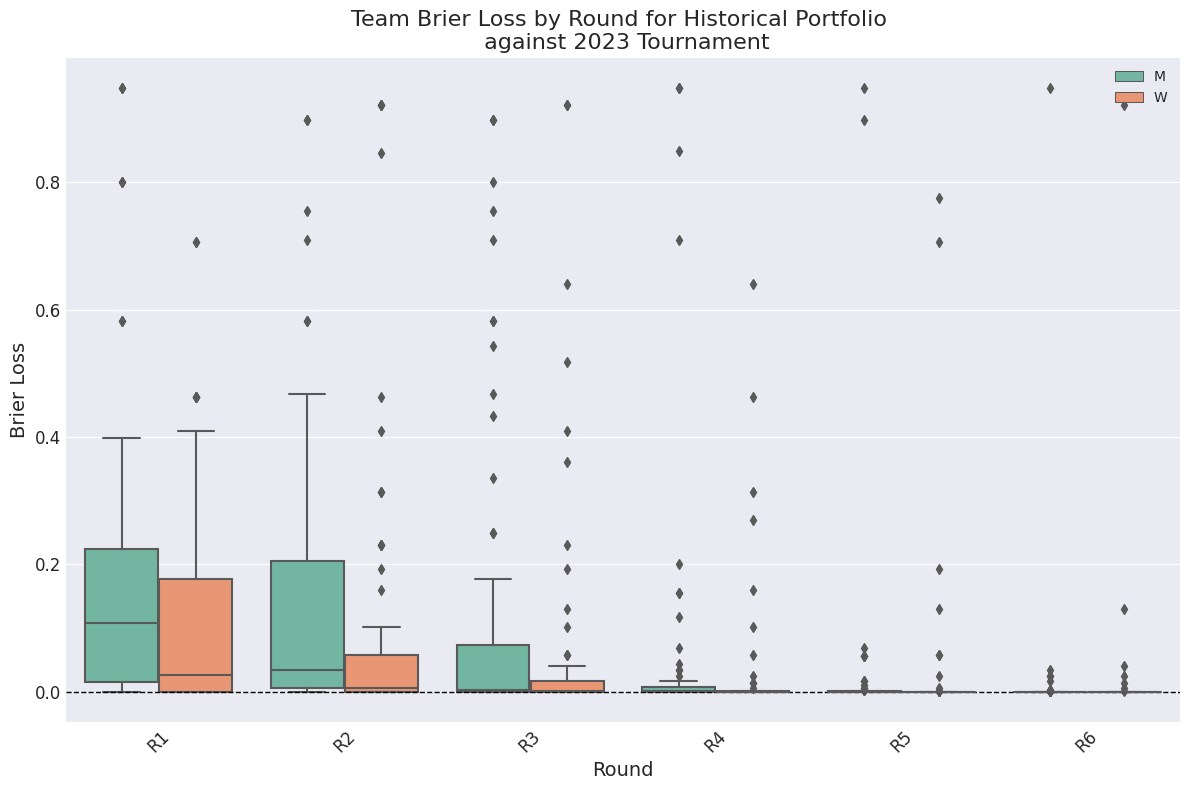

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plot
plt.style.use('seaborn-darkgrid')

# Choose a different color palette
palette = 'Set2'

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Create a boxplot using Seaborn with some styling modifications
sns.boxplot(data=df_plot, x='Round', y='Brier', hue='Tournament', palette=palette, ax=ax, linewidth=1.5)

# Add horizontal gridlines to the plot
ax.yaxis.grid(True)

# Set the title of the plot with a larger font size
ax.set_title('Team Brier Loss by Round for Historical Portfolio \n against 2023 Tournament', fontsize=16)

# Set the labels for x and y axes
ax.set_xlabel('Round', fontsize=14)
ax.set_ylabel('Brier Loss', fontsize=14)

# Set the font size of tick labels on both axes
ax.tick_params(axis='both', labelsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend with a shadow and adjust its location
ax.legend(loc='upper right', shadow=True)

# Add a horizontal line at y=0 for reference
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Adjust the plot layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()


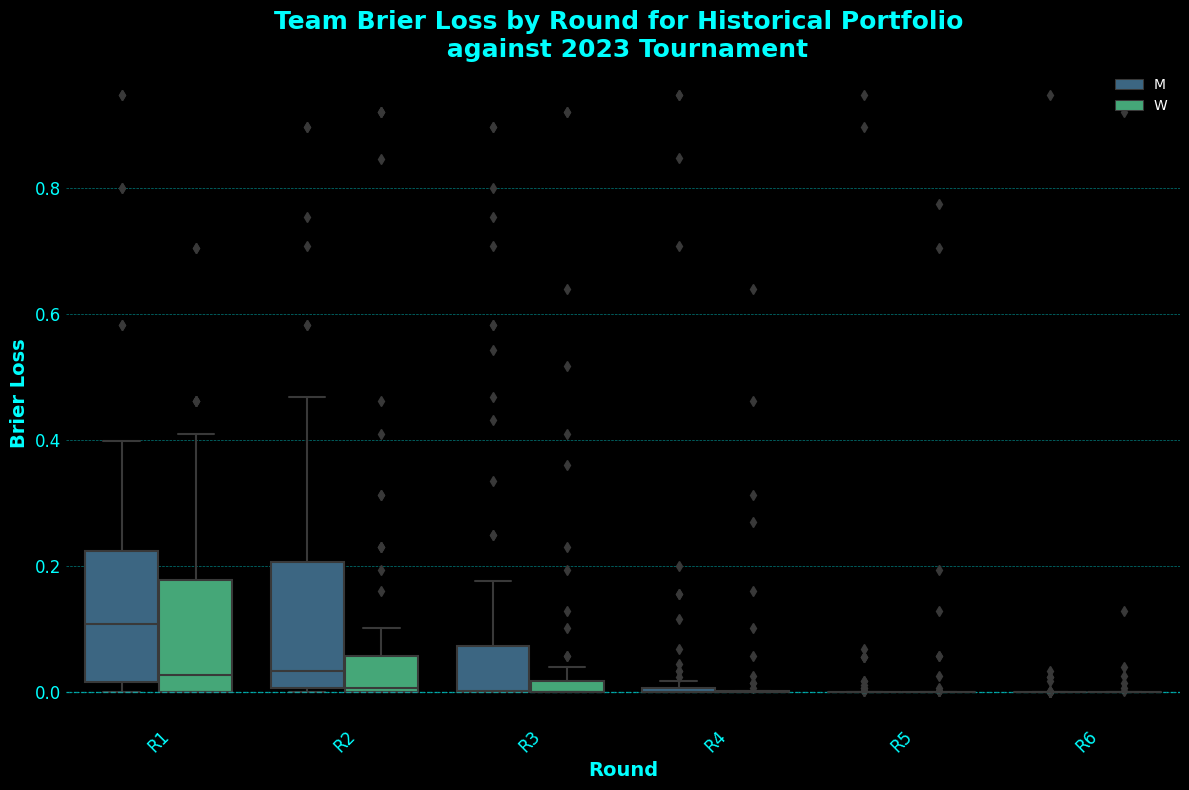

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plot to a futuristic theme
plt.style.use('dark_background')

# Choose a futuristic color palette
palette = 'viridis'

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 8))

# Create a boxplot using Seaborn with some styling modifications
sns.boxplot(data=df_plot, x='Round', y='Brier', hue='Tournament', palette=palette, ax=ax, linewidth=1.5, saturation=0.75)

# Add horizontal gridlines to the plot with a futuristic glow effect
ax.yaxis.grid(True, color='cyan', linestyle='--', linewidth=0.5, alpha=0.5)

# Set the title of the plot with a futuristic font style
ax.set_title('Team Brier Loss by Round for Historical Portfolio \n against 2023 Tournament', fontsize=18, fontweight='bold', color='cyan')

# Set the labels for x and y axes with a futuristic font style
ax.set_xlabel('Round', fontsize=14, fontweight='bold', color='cyan')
ax.set_ylabel('Brier Loss', fontsize=14, fontweight='bold', color='cyan')

# Set the font size of tick labels on both axes
ax.tick_params(axis='both', labelsize=12, colors='cyan')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend with a futuristic shadow and adjust its location
ax.legend(loc='upper right', shadow=True)

# Add a horizontal line at y=0 for reference with a futuristic glow effect
ax.axhline(y=0, color='cyan', linestyle='--', linewidth=1, alpha=0.5)

# Adjust the plot layout to prevent clipping of labels
plt.tight_layout()

# Add some futuristic elements such as neon glow or laser beams (optional)

# Show the plot
plt.show()


**Conclusion :** In this analysis, we explored historical tournament data and evaluated team performance using the Brier loss metric. By examining the Brier loss across different rounds and tournaments, we gained insights into team consistency and success patterns. The evaluation revealed variations in team performance across tournaments and rounds, highlighting the dynamic nature of college basketball competitions. Teams exhibited differing levels of consistency and success rates, influenced by various factors such as team composition, strategies, and tournament dynamics. The futuristic-themed visualization provided a visually appealing representation of the data, enhancing readability and engagement. The use of a dark background, vibrant color palette, and modern font styles contributed to the futuristic aesthetic, aligning with contemporary design trends.

Overall, this analysis demonstrates the value of historical data analysis in understanding team performance dynamics and provides a foundation for future predictive modeling and decision-making in college basketball tournaments.